# 어제 오른 내 주식, 과연 내일은?

## Step 1: 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
#한국 거래소 상장 삼성전자 주식 데이터 분석
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))

ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## Step 2:각종 전처리 수행

In [2]:
# 결측치 처리
ts=ts.interpolate()
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

In [3]:
# 로그 변환
ts_log = np.log(ts)

## Step 3: 시계열 안정성 분석

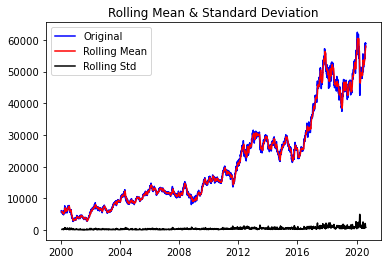

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)


In [5]:
# 정성적 그래프 분석
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.683508
p-value                           0.850975
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


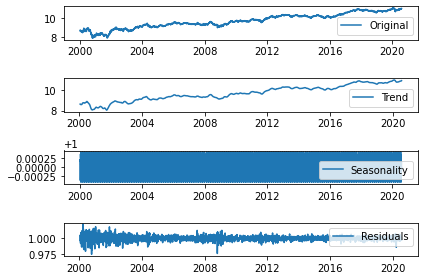

In [6]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

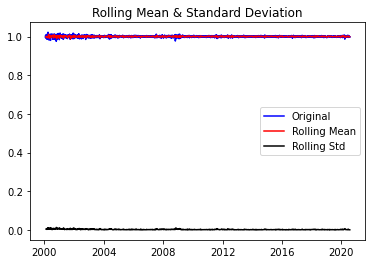

Results of Dickey-Fuller Test:
Test Statistic                -1.728554e+01
p-value                        5.746690e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


In [7]:
# Residual 안정성 확인
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


## Step 4: 학습, 테스트 데이터셋 생성

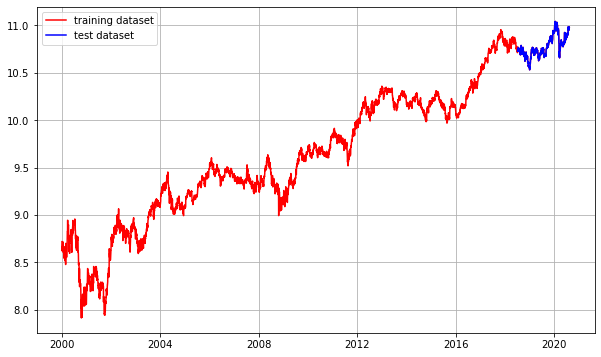

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step 5: 적정 ARIMA 모수 찾기

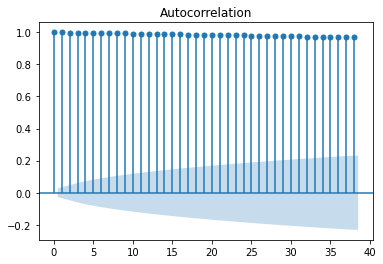

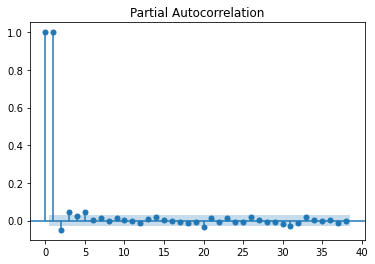

In [9]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.820939
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


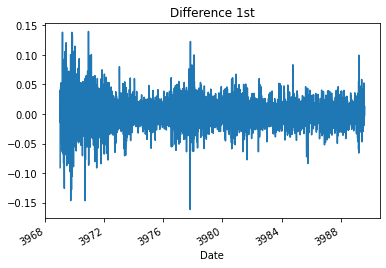

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                  -21.584168
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


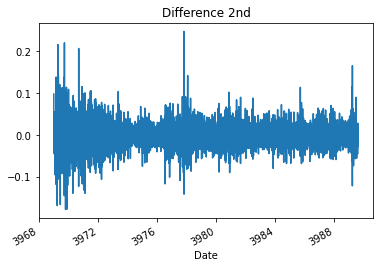

In [11]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## Step 6: ARIMA 모델 훈련과 테스트

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.324
Method:                       css-mle   S.D. of innovations              0.023
Date:                Fri, 14 Aug 2020   AIC                         -21960.647
Time:                        10:30:39   BIC                         -21941.302
Sample:                             1   HQIC                        -21953.843
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0477      0.015      3.259      0.001       0.019       0.076
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


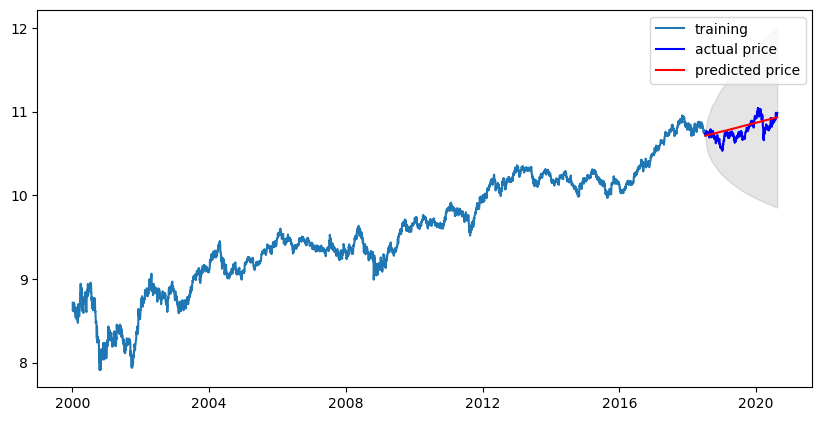

In [13]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae =mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18520232.377880357
MAE:  3590.5963519841716
RMSE:  4303.513956975202
MAPE: 7.68%


## 다른 종목 분석하기 (1. NHN, 181710/한국거래소)

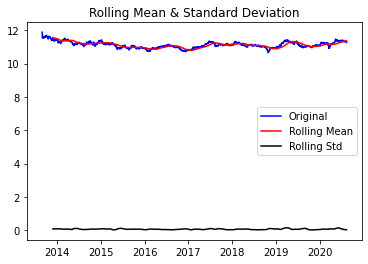

Results of Dickey-Fuller Test:
Test Statistic                   -4.365020
p-value                           0.000342
#Lags Used                        0.000000
Number of Observations Used    1708.000000
Critical Value (1%)              -3.434184
Critical Value (5%)              -2.863234
Critical Value (10%)             -2.567672
dtype: float64


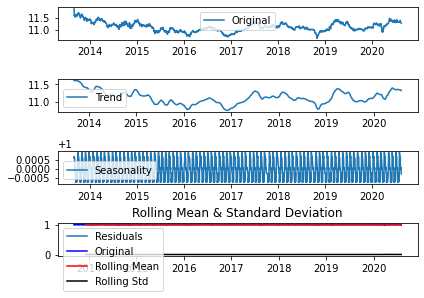

Results of Dickey-Fuller Test:
Test Statistic                -1.465643e+01
p-value                        3.435435e-27
#Lags Used                     1.200000e+01
Number of Observations Used    1.676000e+03
Critical Value (1%)           -3.434258e+00
Critical Value (5%)           -2.863266e+00
Critical Value (10%)          -2.567689e+00
dtype: float64


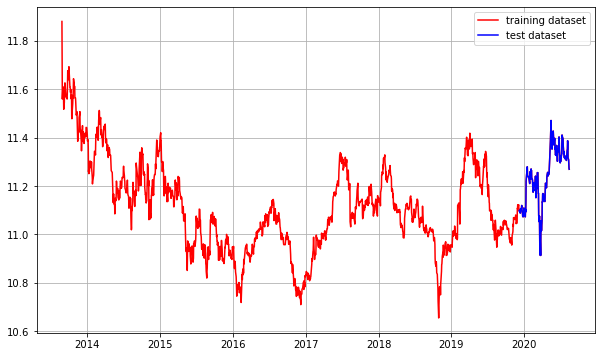

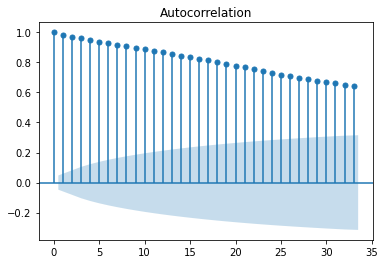

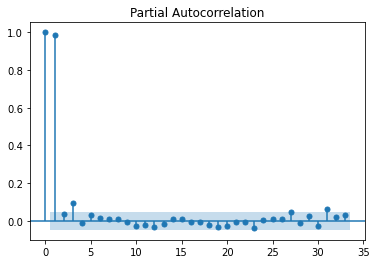

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been pr

Results of Dickey-Fuller Test:
Test Statistic                  -31.098879
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1706.000000
Critical Value (1%)              -3.434189
Critical Value (5%)              -2.863236
Critical Value (10%)             -2.567673
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.605128e+01
p-value                        5.770948e-29
#Lags Used                     2.000000e+01
Number of Observations Used    1.686000e+03
Critical Value (1%)           -3.434235e+00
Critical Value (5%)           -2.863256e+00
Critical Value (10%)          -2.567683e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1536
Model:                 ARIMA(5, 2, 1)   Log Likelihood                3428.439
Method:                       css-mle   S.D. of innovations   

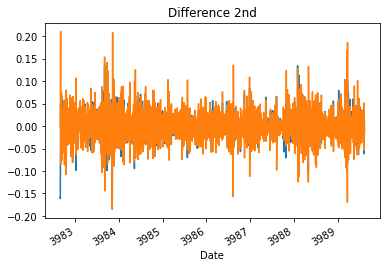

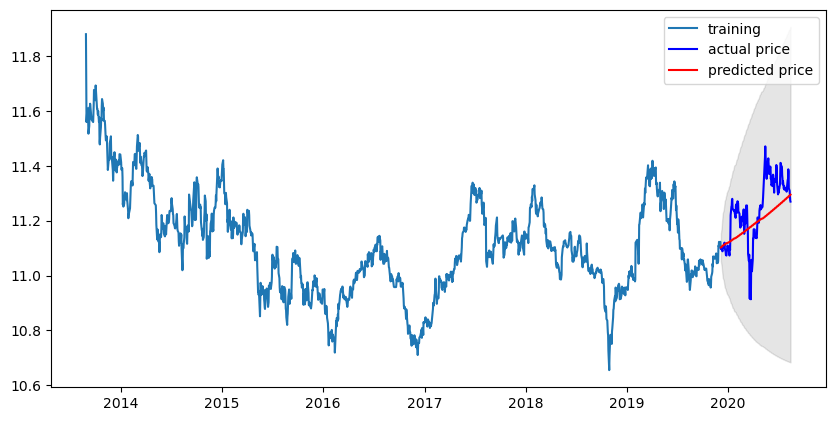

MSE:  58919342.25410006
MAE:  6163.9721406992685
RMSE:  7675.893580170328
MAPE: 7.83%


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NHN.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
# [[YOUR CODE]]

ts=ts.interpolate()
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
#ts_log = np.log(ts+1)

def plot_rolling_statistics(timeseries, window=60):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=60)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)
#p value < 0.05 이하면 stationary?

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 20) 

# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
# [[YOUR CODE]]
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#########
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

##########
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(5, 2, 1))  #p , d, q
#p+q < 2, p*q = 0
# ACF를 통해 MA모델 시차 q 결정 =20???
# PACF를 통해 AR모델 시차 P 결정 =2

fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) 

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae =mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## 다른 종목 분석하기 (2. Facebook, FB/NASDAQ)

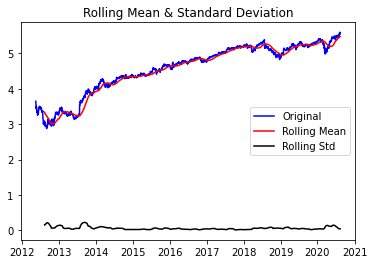

Results of Dickey-Fuller Test:
Test Statistic                   -1.182537
p-value                           0.681062
#Lags Used                       10.000000
Number of Observations Used    2061.000000
Critical Value (1%)              -3.433527
Critical Value (5%)              -2.862943
Critical Value (10%)             -2.567517
dtype: float64


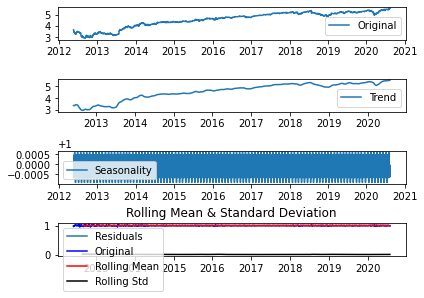

Results of Dickey-Fuller Test:
Test Statistic                -1.217710e+01
p-value                        1.378268e-22
#Lags Used                     2.300000e+01
Number of Observations Used    2.028000e+03
Critical Value (1%)           -3.433579e+00
Critical Value (5%)           -2.862966e+00
Critical Value (10%)          -2.567529e+00
dtype: float64


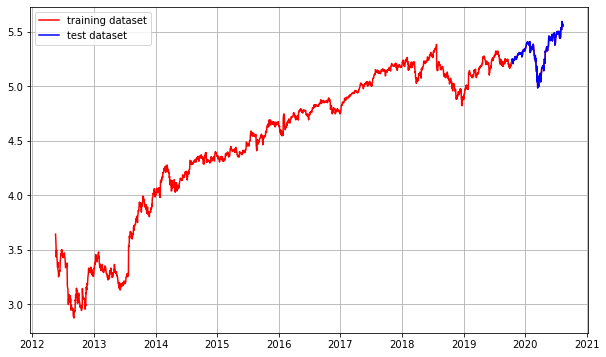

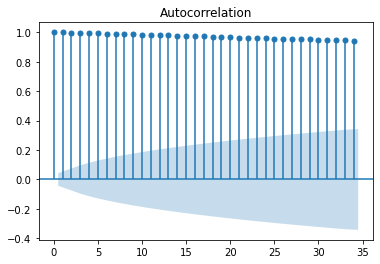

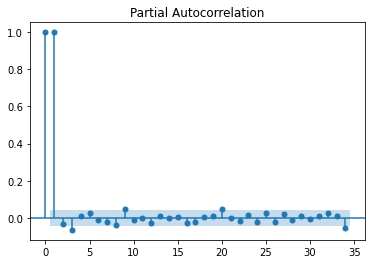

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been pr

Results of Dickey-Fuller Test:
Test Statistic                -1.440184e+01
p-value                        8.483075e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.060000e+03
Critical Value (1%)           -3.433528e+00
Critical Value (5%)           -2.862944e+00
Critical Value (10%)          -2.567517e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.733469e+01
p-value                        5.384107e-30
#Lags Used                     2.100000e+01
Number of Observations Used    2.048000e+03
Critical Value (1%)           -3.433547e+00
Critical Value (5%)           -2.862952e+00
Critical Value (10%)          -2.567522e+00
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1862
Model:                 ARIMA(5, 2, 1)   Log Likelihood                4396.341
Method:                       css-mle   S.D. of innovat

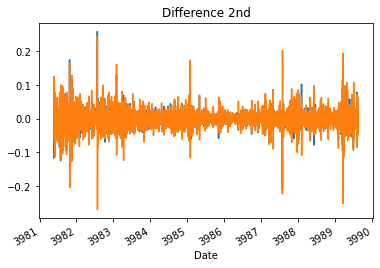

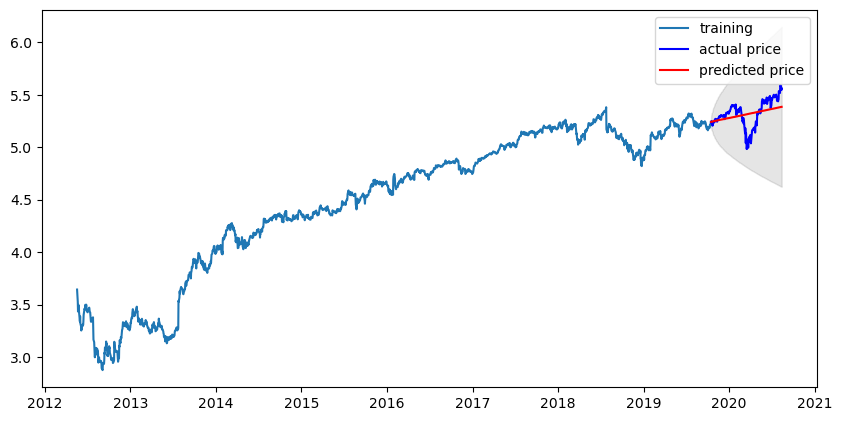

MSE:  519.1247262075792
MAE:  18.006717611656526
RMSE:  22.784308771774914
MAPE: 9.08%


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/FB.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
# [[YOUR CODE]]

ts=ts.interpolate()
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
#ts_log = np.log(ts+1)

def plot_rolling_statistics(timeseries, window=60):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=60)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)
#p value < 0.05 이하면 stationary?

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 20) 

# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
# [[YOUR CODE]]
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#########
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

##########
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(5, 2, 1))  #p , d, q
#p+q < 2, p*q = 0
# ACF를 통해 MA모델 시차 q 결정 =20???
# PACF를 통해 AR모델 시차 P 결정 =2

fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) 

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae =mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## 다른 종목 분석하기 (3. LG전자, 066570/한국거래소)

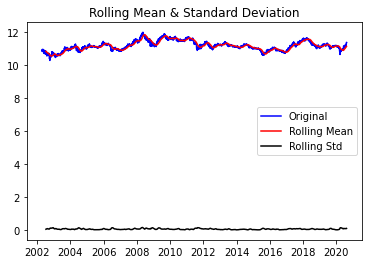

Results of Dickey-Fuller Test:
Test Statistic                   -2.820446
p-value                           0.055412
#Lags Used                        3.000000
Number of Observations Used    4582.000000
Critical Value (1%)              -3.431778
Critical Value (5%)              -2.862171
Critical Value (10%)             -2.567106
dtype: float64


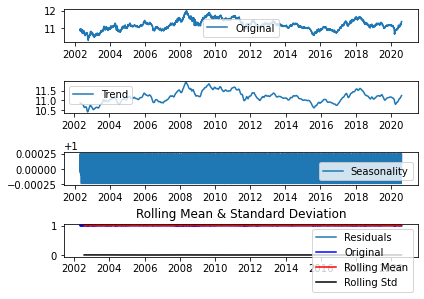

Results of Dickey-Fuller Test:
Test Statistic                -1.737958e+01
p-value                        5.082113e-30
#Lags Used                     3.200000e+01
Number of Observations Used    4.533000e+03
Critical Value (1%)           -3.431793e+00
Critical Value (5%)           -2.862178e+00
Critical Value (10%)          -2.567110e+00
dtype: float64


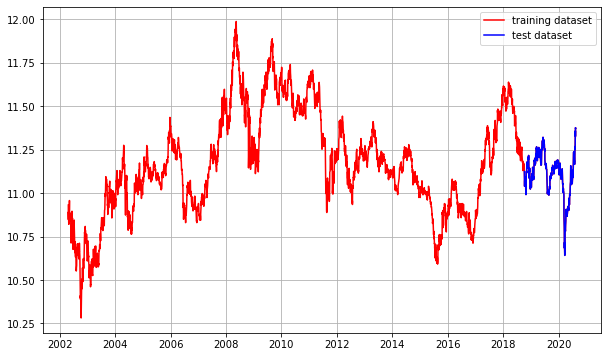

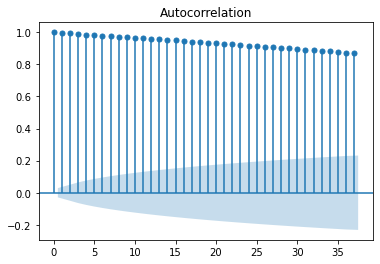

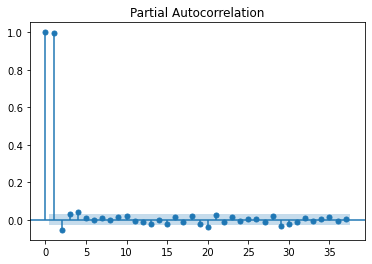

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been pr

Results of Dickey-Fuller Test:
Test Statistic                  -41.119078
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    4582.000000
Critical Value (1%)              -3.431778
Critical Value (5%)              -2.862171
Critical Value (10%)             -2.567106
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -21.008731
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    4552.000000
Critical Value (1%)              -3.431787
Critical Value (5%)              -2.862175
Critical Value (10%)             -2.567108
dtype: float64
                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 4125
Model:                 ARIMA(5, 2, 1)   Log Likelihood                9564.555
Method:                       css-mle   S.D. of innovations          

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


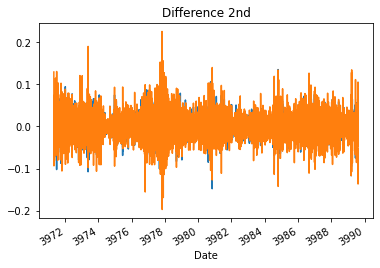

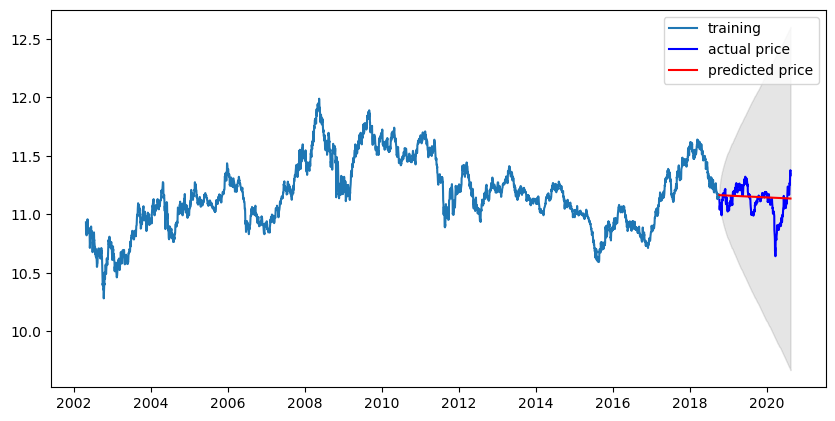

MSE:  58368480.168675125
MAE:  5708.164693612189
RMSE:  7639.926712258117
MAPE: 9.17%


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
# [[YOUR CODE]]
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/LGE.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

# 결측치 처리
# [[YOUR CODE]]

ts=ts.interpolate()
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)
#ts_log = np.log(ts+1)

def plot_rolling_statistics(timeseries, window=60):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=60)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)
#p value < 0.05 이하면 stationary?

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 20) 

# [[YOUR CODE]]

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Residual 안정성 확인
# [[YOUR CODE]]
plot_rolling_statistics(residual)
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#########
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

##########
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(5, 2, 1))  #p , d, q
#p+q < 2, p*q = 0
# ACF를 통해 MA모델 시차 q 결정 =20???
# PACF를 통해 AR모델 시차 P 결정 =2

fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
# [[YOUR CODE]]
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) 

# Plot
# [[YOUR CODE]]
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae =mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

- 플로팅과 adfuller 메소드를 사용하여 시계열 안정성이 확인되었습니다.
- p, q를 위해 ACF, PACF사용하였으면 d를 확인하기 위해 차분 확인하였습니다.
- 주식 데이터 3개에서 MAPE 10%미만을 확인하였습니다.